In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [3]:
# Hyperparameters
train_batch_size = 10
val_batch_size = 10
learning_rate = 0.0001
num_epochs = 200

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [5]:
img = cv2.imread("..\\." + list(DataSplit['train'].keys())[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
print(img.shape)
img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
print(img.shape)

(480, 640, 3)
(120, 160, 3)


In [6]:
# Make Datasets
TrainDataset = Senz3DDataset(list(DataSplit['train'].keys()), list(DataSplit['train'].values()))
ValDataset = Senz3DDataset(list(DataSplit['val'].keys()), list(DataSplit['val'].values()))
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))

In [7]:
#  Make DataLoaders
TrainDataLoader = DataLoader(TrainDataset, batch_size=train_batch_size, shuffle=True)
ValDataLoader = DataLoader(ValDataset, batch_size=val_batch_size, shuffle=True)
TestDataLoader = DataLoader(TestDataset, batch_size=1, shuffle=False)

In [8]:
import torchvision.models as models
model_name = 'resnet18'
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=1000, bias=True),
    nn.ReLU(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500,50),
    nn.ReLU(),
    nn.Linear(50,6),
    nn.Softmax(dim=1),    
    )

for i, param in enumerate(model.parameters()):
    if i < 60:
      print(f'Layer{i} frozen:', type(param), param.size())
      param.requires_grad = False
    else: 
      print(f'Layer{i} not frozen', type(param), param.size())
      param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_metric = nn.CrossEntropyLoss()

Layer0 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
Layer1 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer2 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer3 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer4 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer5 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer6 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer7 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer8 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer9 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer10 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer11 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer12 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer13 frozen: <class 't

In [9]:
# Initialize
epoch_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

epoch_test_loss = []
epoch_test_accuracy = []

best_val_accuracy = 0

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, sample in tqdm.tqdm(enumerate(TrainDataLoader)):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].permute(0, 3, 1, 2).float().to(device)
            y = sample['label'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_metric(output, y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy/loss
        _, y_hat = torch.max(output, dim=1)
        
        train_correct += torch.sum(y_hat == y)
        train_total += x.shape[0]
        train_loss += loss.item() * x.shape[0]
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_loss / train_total)
    epoch_train_accuracy.append(train_correct.float() / train_total)
    
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Train Acc: {epoch_train_accuracy[-1]}')
    
    # Put model in validation mode
    model.eval()
    
    val_total = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for i, sample in enumerate(ValDataLoader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)
            loss = loss_metric(output, y)
            
            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            val_correct += torch.sum(y_hat == y)
            val_total += x.shape[0]
            val_loss += loss.item() * x.shape[0]
            
    # Append to epoch loss/accuracy
    epoch_val_loss.append(val_loss / val_total)
    val_accuracy = val_correct.float() / val_total
    epoch_val_accuracy.append(val_accuracy)
    
#     if val_accuracy > best_val_accuracy:
#         print("Saved new best model.")
#         best_val_accuracy = val_accuracy
#         torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    
    print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Val Acc: {epoch_val_accuracy[-1]}')
    
    

97it [00:10,  9.20it/s]


Epoch: 0, Train Loss: 1.7339728402200145, Train Acc: 0.2834891080856323


2it [00:00, 10.86it/s]

Epoch: 0, Val Loss: 1.6852866857171915, Val Acc: 0.28776979446411133


97it [00:08, 10.84it/s]


Epoch: 1, Train Loss: 1.6199412651646299, Train Acc: 0.4413292109966278


2it [00:00, 11.23it/s]

Epoch: 1, Val Loss: 1.5408667806241152, Val Acc: 0.5899280905723572


97it [00:08, 10.82it/s]


Epoch: 2, Train Loss: 1.506218428676126, Train Acc: 0.5898234844207764


0it [00:00, ?it/s]

Epoch: 2, Val Loss: 1.418370154264162, Val Acc: 0.6978417634963989


97it [00:08, 10.82it/s]


Epoch: 3, Train Loss: 1.4247195182188277, Train Acc: 0.6666666865348816


2it [00:00, 11.22it/s]

Epoch: 3, Val Loss: 1.4036577030909148, Val Acc: 0.661870539188385


97it [00:08, 11.03it/s]


Epoch: 4, Train Loss: 1.3879590272160705, Train Acc: 0.683281421661377


2it [00:00, 11.17it/s]

Epoch: 4, Val Loss: 1.3562592696800506, Val Acc: 0.7194244861602783


97it [00:08, 11.01it/s]


Epoch: 5, Train Loss: 1.3558589769672382, Train Acc: 0.712357223033905


0it [00:00, ?it/s]

Epoch: 5, Val Loss: 1.331360437887178, Val Acc: 0.7194244861602783


97it [00:08, 10.87it/s]


Epoch: 6, Train Loss: 1.3443719815861275, Train Acc: 0.721703052520752


0it [00:00, ?it/s]

Epoch: 6, Val Loss: 1.3232556392820618, Val Acc: 0.7122302055358887


97it [00:08, 10.99it/s]


Epoch: 7, Train Loss: 1.3248760721270045, Train Acc: 0.7289720177650452


0it [00:00, ?it/s]

Epoch: 7, Val Loss: 1.372312902546615, Val Acc: 0.6834532618522644


97it [00:08, 11.06it/s]


Epoch: 8, Train Loss: 1.3094817070698566, Train Acc: 0.740394651889801


0it [00:00, ?it/s]

Epoch: 8, Val Loss: 1.3023862967388236, Val Acc: 0.7338129878044128


97it [00:08, 10.79it/s]


Epoch: 9, Train Loss: 1.3093918205421662, Train Acc: 0.7445483207702637


0it [00:00, ?it/s]

Epoch: 9, Val Loss: 1.3087893175564225, Val Acc: 0.7338129878044128


97it [00:09, 10.74it/s]


Epoch: 10, Train Loss: 1.3231078034744579, Train Acc: 0.7372793555259705


0it [00:00, ?it/s]

Epoch: 10, Val Loss: 1.3277926873817718, Val Acc: 0.7194244861602783


97it [00:08, 11.01it/s]


Epoch: 11, Train Loss: 1.3027933710955881, Train Acc: 0.75077885389328


2it [00:00, 11.42it/s]

Epoch: 11, Val Loss: 1.3041203871047755, Val Acc: 0.7482014298439026


97it [00:08, 11.06it/s]


Epoch: 12, Train Loss: 1.2930288030103483, Train Acc: 0.7580478191375732


2it [00:00, 11.22it/s]

Epoch: 12, Val Loss: 1.2923201880009054, Val Acc: 0.7553957104682922


97it [00:08, 11.17it/s]


Epoch: 13, Train Loss: 1.293785399118069, Train Acc: 0.7559709548950195


0it [00:00, ?it/s]

Epoch: 13, Val Loss: 1.299043609941606, Val Acc: 0.7410072088241577


97it [00:08, 11.02it/s]


Epoch: 14, Train Loss: 1.2897497942885878, Train Acc: 0.7622014880180359


0it [00:00, ?it/s]

Epoch: 14, Val Loss: 1.2787179492360397, Val Acc: 0.7769784331321716


97it [00:08, 11.04it/s]


Epoch: 15, Train Loss: 1.2804835956787395, Train Acc: 0.7642783522605896


0it [00:00, ?it/s]

Epoch: 15, Val Loss: 1.2851737231659375, Val Acc: 0.7625899314880371


97it [00:08, 11.06it/s]


Epoch: 16, Train Loss: 1.3017797847650752, Train Acc: 0.7518172860145569


0it [00:00, ?it/s]

Epoch: 16, Val Loss: 1.2715291350865536, Val Acc: 0.7841726541519165


97it [00:08, 11.09it/s]


Epoch: 17, Train Loss: 1.2797069634975302, Train Acc: 0.771547257900238


0it [00:00, ?it/s]

Epoch: 17, Val Loss: 1.2881486638844442, Val Acc: 0.7697842121124268


97it [00:08, 11.04it/s]


Epoch: 18, Train Loss: 1.2775171251188062, Train Acc: 0.7767394185066223


0it [00:00, ?it/s]

Epoch: 18, Val Loss: 1.2761980235147818, Val Acc: 0.7625899314880371


97it [00:08, 11.05it/s]


Epoch: 19, Train Loss: 1.2678435872524574, Train Acc: 0.7788162231445312


0it [00:00, ?it/s]

Epoch: 19, Val Loss: 1.2685592954964946, Val Acc: 0.7697842121124268


97it [00:08, 11.18it/s]


Epoch: 20, Train Loss: 1.2701929253086, Train Acc: 0.7777777910232544


2it [00:00, 11.42it/s]

Epoch: 20, Val Loss: 1.268279531019197, Val Acc: 0.7697842121124268


97it [00:08, 11.00it/s]


Epoch: 21, Train Loss: 1.2735739537860002, Train Acc: 0.771547257900238


0it [00:00, ?it/s]

Epoch: 21, Val Loss: 1.2609751576142345, Val Acc: 0.7913669347763062


97it [00:08, 10.84it/s]


Epoch: 22, Train Loss: 1.2698764775029596, Train Acc: 0.7767394185066223


2it [00:00, 10.86it/s]

Epoch: 22, Val Loss: 1.2956643284653588, Val Acc: 0.7553957104682922


97it [00:08, 10.79it/s]


Epoch: 23, Train Loss: 1.2641475501461563, Train Acc: 0.7777777910232544


0it [00:00, ?it/s]

Epoch: 23, Val Loss: 1.268874423966991, Val Acc: 0.7697842121124268


97it [00:08, 10.88it/s]


Epoch: 24, Train Loss: 1.2727746904082016, Train Acc: 0.7736241221427917


0it [00:00, ?it/s]

Epoch: 24, Val Loss: 1.2641209492580496, Val Acc: 0.7697842121124268


97it [00:08, 11.03it/s]


Epoch: 25, Train Loss: 1.2585167657053977, Train Acc: 0.7860851883888245


0it [00:00, ?it/s]

Epoch: 25, Val Loss: 1.2599670398149558, Val Acc: 0.7913669347763062


97it [00:08, 11.10it/s]


Epoch: 26, Train Loss: 1.2561831631516867, Train Acc: 0.791277289390564


2it [00:00, 11.16it/s]

Epoch: 26, Val Loss: 1.272449344182186, Val Acc: 0.7769784331321716


97it [00:08, 11.14it/s]


Epoch: 27, Train Loss: 1.2658241614621994, Train Acc: 0.7819315195083618


0it [00:00, ?it/s]

Epoch: 27, Val Loss: 1.2583453500871178, Val Acc: 0.7913669347763062


97it [00:09, 10.73it/s]


Epoch: 28, Train Loss: 1.2617046495092992, Train Acc: 0.7850467562675476


0it [00:00, ?it/s]

Epoch: 28, Val Loss: 1.272218776263779, Val Acc: 0.7625899314880371


97it [00:08, 11.15it/s]


Epoch: 29, Train Loss: 1.2503064152855243, Train Acc: 0.7943925857543945


0it [00:00, ?it/s]

Epoch: 29, Val Loss: 1.2448729122285362, Val Acc: 0.8057554364204407


97it [00:08, 11.28it/s]


Epoch: 30, Train Loss: 1.2401013753124486, Train Acc: 0.8151609897613525


2it [00:00, 11.10it/s]

Epoch: 30, Val Loss: 1.2493667431014905, Val Acc: 0.8129496574401855


97it [00:08, 11.26it/s]


Epoch: 31, Train Loss: 1.2141718209594456, Train Acc: 0.8421599268913269


2it [00:00, 10.86it/s]

Epoch: 31, Val Loss: 1.2145493673763688, Val Acc: 0.8561151027679443


97it [00:08, 11.09it/s]


Epoch: 32, Train Loss: 1.2273623890099372, Train Acc: 0.8245067596435547


0it [00:00, ?it/s]

Epoch: 32, Val Loss: 1.1869758590519857, Val Acc: 0.8705036044120789


97it [00:08, 10.83it/s]


Epoch: 33, Train Loss: 1.1958739360173543, Train Acc: 0.8577362895011902


0it [00:00, ?it/s]

Epoch: 33, Val Loss: 1.1563441641896748, Val Acc: 0.9136691093444824


97it [00:09, 10.72it/s]


Epoch: 34, Train Loss: 1.1630129991166935, Train Acc: 0.8971962928771973


0it [00:00, ?it/s]

Epoch: 34, Val Loss: 1.1499758487125096, Val Acc: 0.9208633303642273


97it [00:09, 10.77it/s]


Epoch: 35, Train Loss: 1.1429067763460263, Train Acc: 0.9158878922462463


1it [00:00,  9.99it/s]

Epoch: 35, Val Loss: 1.1314259999089962, Val Acc: 0.9136691093444824


97it [00:09, 10.73it/s]


Epoch: 36, Train Loss: 1.1316860612183963, Train Acc: 0.928348958492279


0it [00:00, ?it/s]

Epoch: 36, Val Loss: 1.1415433703566626, Val Acc: 0.9064748287200928


97it [00:08, 10.84it/s]


Epoch: 37, Train Loss: 1.1063106628221886, Train Acc: 0.9501557946205139


1it [00:00,  9.99it/s]

Epoch: 37, Val Loss: 1.1107511057270516, Val Acc: 0.9352518320083618


97it [00:09, 10.68it/s]


Epoch: 38, Train Loss: 1.1019367052634805, Train Acc: 0.9563863277435303


0it [00:00, ?it/s]

Epoch: 38, Val Loss: 1.1233013362335644, Val Acc: 0.9208633303642273


97it [00:09, 10.71it/s]


Epoch: 39, Train Loss: 1.1021036185703297, Train Acc: 0.9605399966239929


0it [00:00, ?it/s]

Epoch: 39, Val Loss: 1.1040423851219012, Val Acc: 0.9424460530281067


97it [00:09, 10.61it/s]


Epoch: 40, Train Loss: 1.0975098513368506, Train Acc: 0.9595016241073608


0it [00:00, ?it/s]

Epoch: 40, Val Loss: 1.1068296415342702, Val Acc: 0.9424460530281067


97it [00:09, 10.71it/s]


Epoch: 41, Train Loss: 1.0925092294827676, Train Acc: 0.9574247598648071


0it [00:00, ?it/s]

Epoch: 41, Val Loss: 1.132951631820459, Val Acc: 0.8920863270759583


97it [00:08, 11.00it/s]


Epoch: 42, Train Loss: 1.0831765778215752, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Epoch: 42, Val Loss: 1.1243526112261435, Val Acc: 0.9280575513839722


97it [00:08, 10.97it/s]


Epoch: 43, Train Loss: 1.0795772226676268, Train Acc: 0.9719626307487488


2it [00:00, 11.16it/s]

Epoch: 43, Val Loss: 1.1081810872331799, Val Acc: 0.9280575513839722


97it [00:09, 10.65it/s]


Epoch: 44, Train Loss: 1.0809926180824685, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 44, Val Loss: 1.144867433060845, Val Acc: 0.8992806077003479


97it [00:08, 10.89it/s]


Epoch: 45, Train Loss: 1.0675669339091856, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 45, Val Loss: 1.0943442214307169, Val Acc: 0.9568345546722412


97it [00:08, 10.79it/s]


Epoch: 46, Train Loss: 1.0741835659290524, Train Acc: 0.9781931638717651


0it [00:00, ?it/s]

Epoch: 46, Val Loss: 1.1010460407613851, Val Acc: 0.9496403336524963


97it [00:08, 11.24it/s]


Epoch: 47, Train Loss: 1.072821115160038, Train Acc: 0.9761163592338562


0it [00:00, ?it/s]

Epoch: 47, Val Loss: 1.0922000305258113, Val Acc: 0.9568345546722412


97it [00:08, 11.07it/s]


Epoch: 48, Train Loss: 1.0769790797218728, Train Acc: 0.9771547913551331


2it [00:00, 11.04it/s]

Epoch: 48, Val Loss: 1.086721338814111, Val Acc: 0.9640287756919861


97it [00:08, 11.04it/s]


Epoch: 49, Train Loss: 1.0633653998993886, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 49, Val Loss: 1.094248420900578, Val Acc: 0.9568345546722412


97it [00:08, 10.91it/s]


Epoch: 50, Train Loss: 1.0656239215211085, Train Acc: 0.9875389933586121


2it [00:00, 11.16it/s]

Epoch: 50, Val Loss: 1.0972817252865799, Val Acc: 0.9424460530281067


97it [00:08, 11.17it/s]


Epoch: 51, Train Loss: 1.0642646981919666, Train Acc: 0.9854621291160583


2it [00:00, 11.23it/s]

Epoch: 51, Val Loss: 1.113509813658625, Val Acc: 0.9208633303642273


97it [00:08, 11.20it/s]


Epoch: 52, Train Loss: 1.0599721974672929, Train Acc: 0.989615797996521


0it [00:00, ?it/s]

Epoch: 52, Val Loss: 1.0834856805183906, Val Acc: 0.9640287756919861


97it [00:08, 11.08it/s]


Epoch: 53, Train Loss: 1.0846045534682547, Train Acc: 0.9678089618682861


2it [00:00, 11.35it/s]

Epoch: 53, Val Loss: 1.1291996489325873, Val Acc: 0.9136691093444824


97it [00:08, 11.12it/s]


Epoch: 54, Train Loss: 1.0682354123173967, Train Acc: 0.979231595993042


2it [00:00, 11.48it/s]

Epoch: 54, Val Loss: 1.0888531679729763, Val Acc: 0.9640287756919861


97it [00:08, 11.29it/s]


Epoch: 55, Train Loss: 1.0595983070005137, Train Acc: 0.9885774254798889


2it [00:00, 11.23it/s]

Epoch: 55, Val Loss: 1.0831515746150944, Val Acc: 0.9712230563163757


97it [00:08, 11.31it/s]


Epoch: 56, Train Loss: 1.0561578469360604, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 56, Val Loss: 1.0782772705709334, Val Acc: 0.9640287756919861


97it [00:08, 11.19it/s]


Epoch: 57, Train Loss: 1.0621891062579052, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 57, Val Loss: 1.0754963519761889, Val Acc: 0.9640287756919861


97it [00:08, 10.88it/s]


Epoch: 58, Train Loss: 1.0531346905639982, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 58, Val Loss: 1.0764157085967578, Val Acc: 0.9784172773361206


97it [00:08, 11.10it/s]


Epoch: 59, Train Loss: 1.0483693593759031, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 59, Val Loss: 1.0824683870342995, Val Acc: 0.9640287756919861


97it [00:09, 10.78it/s]


Epoch: 60, Train Loss: 1.0625338337750698, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 60, Val Loss: 1.0711439290492655, Val Acc: 0.9856115579605103


97it [00:08, 11.10it/s]


Epoch: 61, Train Loss: 1.0585949087935198, Train Acc: 0.9885774254798889


2it [00:00, 11.23it/s]

Epoch: 61, Val Loss: 1.081418073434624, Val Acc: 0.9712230563163757


97it [00:08, 11.31it/s]


Epoch: 62, Train Loss: 1.0576517413585975, Train Acc: 0.9906542301177979


2it [00:00, 11.42it/s]

Epoch: 62, Val Loss: 1.0854128959367602, Val Acc: 0.9784172773361206


97it [00:08, 11.33it/s]


Epoch: 63, Train Loss: 1.0581553897134734, Train Acc: 0.9906542301177979


2it [00:00, 11.20it/s]

Epoch: 63, Val Loss: 1.0693979048900466, Val Acc: 0.9856115579605103


97it [00:08, 11.31it/s]


Epoch: 64, Train Loss: 1.0624130116321093, Train Acc: 0.9844236969947815


2it [00:00, 11.29it/s]

Epoch: 64, Val Loss: 1.0886386735833806, Val Acc: 0.9568345546722412


97it [00:08, 10.96it/s]


Epoch: 65, Train Loss: 1.0524329549922131, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 65, Val Loss: 1.09379812967863, Val Acc: 0.9424460530281067


97it [00:08, 11.00it/s]


Epoch: 66, Train Loss: 1.0524152737664036, Train Acc: 0.9948079586029053


2it [00:00, 11.35it/s]

Epoch: 66, Val Loss: 1.081202203421284, Val Acc: 0.9784172773361206


97it [00:08, 11.21it/s]


Epoch: 67, Train Loss: 1.0553580497779331, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 67, Val Loss: 1.098796252724078, Val Acc: 0.9496403336524963


97it [00:08, 11.04it/s]


Epoch: 68, Train Loss: 1.0564018362902903, Train Acc: 0.9885774254798889


2it [00:00, 10.92it/s]

Epoch: 68, Val Loss: 1.0774596372096659, Val Acc: 0.9640287756919861


97it [00:08, 11.21it/s]


Epoch: 69, Train Loss: 1.0521599547018763, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 69, Val Loss: 1.1154068922824998, Val Acc: 0.9208633303642273


97it [00:09, 10.77it/s]


Epoch: 70, Train Loss: 1.055561097735309, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 70, Val Loss: 1.0739373414636515, Val Acc: 0.9784172773361206


97it [00:08, 10.91it/s]


Epoch: 71, Train Loss: 1.0495666366995062, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 71, Val Loss: 1.1011017912583385, Val Acc: 0.9496403336524963


97it [00:08, 11.17it/s]


Epoch: 72, Train Loss: 1.0530899946315762, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 72, Val Loss: 1.0651493647115693, Val Acc: 0.9784172773361206


97it [00:08, 11.28it/s]


Epoch: 73, Train Loss: 1.0580765288690663, Train Acc: 0.9885774254798889


2it [00:00, 11.62it/s]

Epoch: 73, Val Loss: 1.0806102924209704, Val Acc: 0.9712230563163757


97it [00:08, 11.24it/s]


Epoch: 74, Train Loss: 1.0631343744006607, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 74, Val Loss: 1.0771131155302198, Val Acc: 0.9640287756919861


97it [00:08, 11.14it/s]


Epoch: 75, Train Loss: 1.0585422923136598, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 75, Val Loss: 1.0689982707551915, Val Acc: 0.9784172773361206


97it [00:08, 11.17it/s]


Epoch: 76, Train Loss: 1.0527892612841518, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 76, Val Loss: 1.0565258221660587, Val Acc: 0.9928057789802551


97it [00:08, 10.99it/s]


Epoch: 77, Train Loss: 1.0515231360775164, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 77, Val Loss: 1.0676737809352737, Val Acc: 0.9856115579605103


97it [00:08, 10.93it/s]


Epoch: 78, Train Loss: 1.0521839621901388, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 78, Val Loss: 1.0782540796472013, Val Acc: 0.9640287756919861


97it [00:08, 11.30it/s]


Epoch: 79, Train Loss: 1.0528753748316384, Train Acc: 0.9937695264816284


2it [00:00, 11.23it/s]

Epoch: 79, Val Loss: 1.0695475803004753, Val Acc: 0.9784172773361206


97it [00:08, 11.32it/s]


Epoch: 80, Train Loss: 1.049330248144433, Train Acc: 0.9968847632408142


2it [00:00, 11.42it/s]

Epoch: 80, Val Loss: 1.0634102761316642, Val Acc: 0.9856115579605103


97it [00:08, 11.31it/s]


Epoch: 81, Train Loss: 1.0537411449854248, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 81, Val Loss: 1.085281596766959, Val Acc: 0.9568345546722412


97it [00:08, 10.91it/s]


Epoch: 82, Train Loss: 1.05232032895212, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 82, Val Loss: 1.0964282227934694, Val Acc: 0.9568345546722412


97it [00:08, 10.81it/s]


Epoch: 83, Train Loss: 1.0560176158372239, Train Acc: 0.9906542301177979


2it [00:00, 11.42it/s]

Epoch: 83, Val Loss: 1.0776381123837808, Val Acc: 0.9712230563163757


97it [00:08, 11.26it/s]


Epoch: 84, Train Loss: 1.0660426362900224, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 84, Val Loss: 1.0680834560943164, Val Acc: 0.9856115579605103


97it [00:08, 11.19it/s]


Epoch: 85, Train Loss: 1.0479717331388163, Train Acc: 0.9968847632408142


2it [00:00, 11.35it/s]

Epoch: 85, Val Loss: 1.059513584315348, Val Acc: 0.9784172773361206


97it [00:08, 11.26it/s]


Epoch: 86, Train Loss: 1.046589830458969, Train Acc: 0.9989616274833679


2it [00:00, 11.35it/s]

Epoch: 86, Val Loss: 1.0692037952889641, Val Acc: 0.9784172773361206


97it [00:08, 11.01it/s]


Epoch: 87, Train Loss: 1.049180905643158, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 87, Val Loss: 1.0586635217392186, Val Acc: 1.0


97it [00:08, 10.94it/s]


Epoch: 88, Train Loss: 1.0524322799680637, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 88, Val Loss: 1.0833619369877328, Val Acc: 0.9640287756919861


97it [00:08, 10.84it/s]


Epoch: 89, Train Loss: 1.0540824445237251, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 89, Val Loss: 1.0804072781432448, Val Acc: 0.9640287756919861


97it [00:09, 10.76it/s]


Epoch: 90, Train Loss: 1.05079417213844, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 90, Val Loss: 1.063264571505485, Val Acc: 0.9856115579605103


97it [00:08, 11.22it/s]


Epoch: 91, Train Loss: 1.0516708316832688, Train Acc: 0.9958463311195374


2it [00:00, 11.35it/s]

Epoch: 91, Val Loss: 1.0650373894533665, Val Acc: 0.9784172773361206


97it [00:08, 11.26it/s]


Epoch: 92, Train Loss: 1.0479044326245475, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 92, Val Loss: 1.0604142216469745, Val Acc: 0.9856115579605103


97it [00:08, 11.26it/s]


Epoch: 93, Train Loss: 1.0504898391161133, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 93, Val Loss: 1.0919102010109443, Val Acc: 0.9568345546722412


97it [00:08, 11.06it/s]


Epoch: 94, Train Loss: 1.0495706240831257, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 94, Val Loss: 1.0537498606194695, Val Acc: 0.9928057789802551


97it [00:08, 10.81it/s]


Epoch: 95, Train Loss: 1.0500949539499491, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 95, Val Loss: 1.068541456469529, Val Acc: 0.9784172773361206


97it [00:08, 11.08it/s]


Epoch: 96, Train Loss: 1.0506297810426755, Train Acc: 0.9937695264816284


2it [00:00, 11.04it/s]

Epoch: 96, Val Loss: 1.075461663788171, Val Acc: 0.9712230563163757


97it [00:08, 11.27it/s]


Epoch: 97, Train Loss: 1.0553796876875658, Train Acc: 0.9906542301177979


2it [00:00, 11.23it/s]

Epoch: 97, Val Loss: 1.0681537724227357, Val Acc: 0.9856115579605103


97it [00:08, 11.21it/s]


Epoch: 98, Train Loss: 1.0596304766733202, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 98, Val Loss: 1.101983099532642, Val Acc: 0.9352518320083618


97it [00:08, 11.25it/s]


Epoch: 99, Train Loss: 1.0487397094629511, Train Acc: 0.9979231953620911


2it [00:00, 11.29it/s]

Epoch: 99, Val Loss: 1.07480422627154, Val Acc: 0.9784172773361206


97it [00:08, 11.23it/s]


Epoch: 100, Train Loss: 1.059913968000085, Train Acc: 0.9865005612373352


2it [00:00, 11.29it/s]

Epoch: 100, Val Loss: 1.0679593832372762, Val Acc: 0.9712230563163757


97it [00:08, 11.20it/s]


Epoch: 101, Train Loss: 1.0519428326209634, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 101, Val Loss: 1.1279039605915975, Val Acc: 0.8992806077003479


97it [00:08, 10.78it/s]


Epoch: 102, Train Loss: 1.0487336021841254, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 102, Val Loss: 1.0757066165800575, Val Acc: 0.9640287756919861


97it [00:08, 11.16it/s]


Epoch: 103, Train Loss: 1.051858111952943, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 103, Val Loss: 1.0783743240850434, Val Acc: 0.9712230563163757


97it [00:08, 11.27it/s]


Epoch: 104, Train Loss: 1.0503467164183207, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 104, Val Loss: 1.0849001081727392, Val Acc: 0.9496403336524963


97it [00:08, 10.93it/s]


Epoch: 105, Train Loss: 1.046922114655484, Train Acc: 1.0


2it [00:00, 10.98it/s]

Epoch: 105, Val Loss: 1.0919077096225547, Val Acc: 0.9568345546722412


97it [00:08, 11.20it/s]


Epoch: 106, Train Loss: 1.0494293296324748, Train Acc: 0.9968847632408142


2it [00:00, 11.23it/s]

Epoch: 106, Val Loss: 1.1061758574821967, Val Acc: 0.9280575513839722


97it [00:08, 10.88it/s]


Epoch: 107, Train Loss: 1.046515073236523, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 107, Val Loss: 1.0662335792033792, Val Acc: 0.9784172773361206


97it [00:08, 11.05it/s]


Epoch: 108, Train Loss: 1.0495066145127436, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 108, Val Loss: 1.0861104881163124, Val Acc: 0.9568345546722412


97it [00:08, 11.25it/s]


Epoch: 109, Train Loss: 1.0475236677554043, Train Acc: 0.9989616274833679


2it [00:00, 11.29it/s]

Epoch: 109, Val Loss: 1.0586858113035023, Val Acc: 0.9928057789802551


97it [00:08, 11.26it/s]


Epoch: 110, Train Loss: 1.0518417822609067, Train Acc: 0.9937695264816284


2it [00:00, 11.23it/s]

Epoch: 110, Val Loss: 1.0735301439710658, Val Acc: 0.9712230563163757


97it [00:08, 11.26it/s]


Epoch: 111, Train Loss: 1.0475927175391129, Train Acc: 0.9979231953620911


2it [00:00, 11.23it/s]

Epoch: 111, Val Loss: 1.0763667779003117, Val Acc: 0.9640287756919861


97it [00:08, 11.26it/s]


Epoch: 112, Train Loss: 1.0601959873458926, Train Acc: 0.9854621291160583


2it [00:00, 11.48it/s]

Epoch: 112, Val Loss: 1.0689739786463677, Val Acc: 0.9712230563163757


97it [00:08, 11.33it/s]


Epoch: 113, Train Loss: 1.0500418767255661, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 113, Val Loss: 1.0798507594376159, Val Acc: 0.9640287756919861


97it [00:08, 10.85it/s]


Epoch: 114, Train Loss: 1.0455258925013082, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 114, Val Loss: 1.0677356582751376, Val Acc: 0.9784172773361206


97it [00:08, 10.97it/s]


Epoch: 115, Train Loss: 1.047489476104887, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 115, Val Loss: 1.0700305726030748, Val Acc: 0.9784172773361206


97it [00:08, 11.23it/s]


Epoch: 116, Train Loss: 1.0557129255583972, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 116, Val Loss: 1.1031296373271255, Val Acc: 0.9424460530281067


97it [00:08, 11.24it/s]


Epoch: 117, Train Loss: 1.0544604554478376, Train Acc: 0.989615797996521


2it [00:00, 11.23it/s]

Epoch: 117, Val Loss: 1.1161671851178725, Val Acc: 0.9280575513839722


97it [00:08, 11.22it/s]


Epoch: 118, Train Loss: 1.0552442521940015, Train Acc: 0.9865005612373352


2it [00:00, 11.16it/s]

Epoch: 118, Val Loss: 1.060530346932171, Val Acc: 0.9856115579605103


97it [00:08, 10.93it/s]


Epoch: 119, Train Loss: 1.0479420654994058, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 119, Val Loss: 1.0668893031936755, Val Acc: 0.9784172773361206


97it [00:08, 10.92it/s]


Epoch: 120, Train Loss: 1.050395718120959, Train Acc: 0.9937695264816284


2it [00:00, 11.42it/s]

Epoch: 120, Val Loss: 1.0928963568570802, Val Acc: 0.9568345546722412


97it [00:08, 11.24it/s]


Epoch: 121, Train Loss: 1.054643438488771, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 121, Val Loss: 1.0828038111007472, Val Acc: 0.9640287756919861


97it [00:08, 11.25it/s]


Epoch: 122, Train Loss: 1.0515556383727125, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 122, Val Loss: 1.079912741407216, Val Acc: 0.9640287756919861


97it [00:08, 11.30it/s]


Epoch: 123, Train Loss: 1.0528807451915643, Train Acc: 0.9927310943603516


2it [00:00, 11.42it/s]

Epoch: 123, Val Loss: 1.0900304360355404, Val Acc: 0.9640287756919861


97it [00:08, 11.28it/s]


Epoch: 124, Train Loss: 1.0482434462659207, Train Acc: 0.9958463311195374


2it [00:00, 11.23it/s]

Epoch: 124, Val Loss: 1.071678448066437, Val Acc: 0.9784172773361206


97it [00:08, 11.23it/s]


Epoch: 125, Train Loss: 1.055753284649438, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 125, Val Loss: 1.0997426655652711, Val Acc: 0.9424460530281067


97it [00:08, 10.81it/s]


Epoch: 126, Train Loss: 1.0491687039596145, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 126, Val Loss: 1.057683529613687, Val Acc: 0.9928057789802551


97it [00:08, 10.87it/s]


Epoch: 127, Train Loss: 1.0472616058767523, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 127, Val Loss: 1.0720730050862264, Val Acc: 0.9640287756919861


97it [00:08, 11.19it/s]


Epoch: 128, Train Loss: 1.0460977622405514, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 128, Val Loss: 1.077409279432228, Val Acc: 0.9640287756919861


97it [00:08, 11.13it/s]


Epoch: 129, Train Loss: 1.0472629382231524, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 129, Val Loss: 1.1099079247001264, Val Acc: 0.9352518320083618


97it [00:08, 11.14it/s]


Epoch: 130, Train Loss: 1.0472973441532962, Train Acc: 0.9979231953620911


2it [00:00, 11.13it/s]

Epoch: 130, Val Loss: 1.0736341219154193, Val Acc: 0.9784172773361206


97it [00:08, 10.87it/s]


Epoch: 131, Train Loss: 1.0497870703971521, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 131, Val Loss: 1.0720338735649053, Val Acc: 0.9712230563163757


97it [00:09, 10.71it/s]


Epoch: 132, Train Loss: 1.04799035367936, Train Acc: 0.9968847632408142


2it [00:00, 11.16it/s]

Epoch: 132, Val Loss: 1.069950988824419, Val Acc: 0.9712230563163757


97it [00:08, 11.19it/s]


Epoch: 133, Train Loss: 1.0572576784022996, Train Acc: 0.9885774254798889


2it [00:00, 11.29it/s]

Epoch: 133, Val Loss: 1.0820028155827695, Val Acc: 0.9640287756919861


97it [00:08, 11.18it/s]


Epoch: 134, Train Loss: 1.0475892421488697, Train Acc: 0.9968847632408142


2it [00:00, 11.42it/s]

Epoch: 134, Val Loss: 1.097044724354641, Val Acc: 0.9424460530281067


97it [00:08, 11.22it/s]


Epoch: 135, Train Loss: 1.0496467328393446, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 135, Val Loss: 1.0759531096588792, Val Acc: 0.9784172773361206


97it [00:08, 11.22it/s]


Epoch: 136, Train Loss: 1.0445400225163002, Train Acc: 1.0


0it [00:00, ?it/s]

Epoch: 136, Val Loss: 1.0963917739099736, Val Acc: 0.9496403336524963


97it [00:08, 11.05it/s]


Epoch: 137, Train Loss: 1.0455123561193638, Train Acc: 0.9989616274833679


2it [00:00, 11.04it/s]

Epoch: 137, Val Loss: 1.058985248744059, Val Acc: 0.9856115579605103


97it [00:08, 11.04it/s]


Epoch: 138, Train Loss: 1.0469573930540312, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 138, Val Loss: 1.063388895645416, Val Acc: 0.9784172773361206


97it [00:08, 10.85it/s]


Epoch: 139, Train Loss: 1.0463161551444826, Train Acc: 0.9979231953620911


2it [00:00, 11.04it/s]

Epoch: 139, Val Loss: 1.0769152598415348, Val Acc: 0.9712230563163757


97it [00:08, 11.24it/s]


Epoch: 140, Train Loss: 1.0466530550801247, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 140, Val Loss: 1.1018468904838288, Val Acc: 0.9496403336524963


97it [00:08, 11.27it/s]


Epoch: 141, Train Loss: 1.0549287231540383, Train Acc: 0.989615797996521


0it [00:00, ?it/s]

Epoch: 141, Val Loss: 1.0619555788932087, Val Acc: 0.9928057789802551


97it [00:08, 11.21it/s]


Epoch: 142, Train Loss: 1.0534043583171762, Train Acc: 0.9906542301177979


2it [00:00, 11.29it/s]

Epoch: 142, Val Loss: 1.0596527744540207, Val Acc: 0.9856115579605103


97it [00:08, 11.19it/s]


Epoch: 143, Train Loss: 1.0489609295952975, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 143, Val Loss: 1.070026588954514, Val Acc: 0.9784172773361206


97it [00:09, 10.49it/s]


Epoch: 144, Train Loss: 1.0501098859347286, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 144, Val Loss: 1.0688480619046328, Val Acc: 0.9784172773361206


97it [00:08, 10.83it/s]


Epoch: 145, Train Loss: 1.0473167344169576, Train Acc: 0.9968847632408142


2it [00:00, 10.98it/s]

Epoch: 145, Val Loss: 1.066359812407185, Val Acc: 0.9784172773361206


97it [00:08, 11.10it/s]


Epoch: 146, Train Loss: 1.0481315455085145, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 146, Val Loss: 1.0734621277816003, Val Acc: 0.9640287756919861


97it [00:08, 10.83it/s]


Epoch: 147, Train Loss: 1.0514805815796737, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 147, Val Loss: 1.0636093539299725, Val Acc: 0.9856115579605103


97it [00:08, 11.05it/s]


Epoch: 148, Train Loss: 1.0509506402109765, Train Acc: 0.9937695264816284


2it [00:00, 11.35it/s]

Epoch: 148, Val Loss: 1.0721164761687354, Val Acc: 0.9784172773361206


97it [00:08, 11.17it/s]


Epoch: 149, Train Loss: 1.049760562237178, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 149, Val Loss: 1.077115866777708, Val Acc: 0.9712230563163757


97it [00:08, 11.02it/s]


Epoch: 150, Train Loss: 1.048931357521382, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 150, Val Loss: 1.0769117341624748, Val Acc: 0.9640287756919861


97it [00:09, 10.74it/s]


Epoch: 151, Train Loss: 1.0484911231855985, Train Acc: 0.9968847632408142


2it [00:00, 11.10it/s]

Epoch: 151, Val Loss: 1.0846971333455697, Val Acc: 0.9640287756919861


97it [00:08, 11.16it/s]


Epoch: 152, Train Loss: 1.0455899790687602, Train Acc: 0.9989616274833679


2it [00:00, 11.35it/s]

Epoch: 152, Val Loss: 1.0835114125725176, Val Acc: 0.9640287756919861


97it [00:08, 11.25it/s]


Epoch: 153, Train Loss: 1.0463242893525992, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 153, Val Loss: 1.0763948409677409, Val Acc: 0.9640287756919861


97it [00:08, 11.18it/s]


Epoch: 154, Train Loss: 1.046200269107878, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 154, Val Loss: 1.0700447859523965, Val Acc: 0.9784172773361206


97it [00:08, 11.18it/s]


Epoch: 155, Train Loss: 1.044930088062029, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 155, Val Loss: 1.068718472830683, Val Acc: 0.9712230563163757


97it [00:09, 10.62it/s]


Epoch: 156, Train Loss: 1.0572817373869947, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 156, Val Loss: 1.0563572610882546, Val Acc: 0.9928057789802551


97it [00:09, 10.72it/s]


Epoch: 157, Train Loss: 1.0448767347870587, Train Acc: 1.0


2it [00:00, 10.74it/s]

Epoch: 157, Val Loss: 1.087639704025049, Val Acc: 0.9568345546722412


97it [00:08, 10.97it/s]


Epoch: 158, Train Loss: 1.0509863628900435, Train Acc: 0.9937695264816284


2it [00:00, 10.86it/s]

Epoch: 158, Val Loss: 1.0651741971214899, Val Acc: 0.9784172773361206


97it [00:09, 10.69it/s]


Epoch: 159, Train Loss: 1.0454742582911396, Train Acc: 1.0


0it [00:00, ?it/s]

Epoch: 159, Val Loss: 1.0757694716076198, Val Acc: 0.9784172773361206


97it [00:08, 10.90it/s]


Epoch: 160, Train Loss: 1.0545699642207145, Train Acc: 0.989615797996521


2it [00:00, 10.98it/s]

Epoch: 160, Val Loss: 1.0659772131940444, Val Acc: 0.9856115579605103


97it [00:08, 11.10it/s]


Epoch: 161, Train Loss: 1.0500929636623506, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 161, Val Loss: 1.080237534406374, Val Acc: 0.9640287756919861


97it [00:08, 11.19it/s]


Epoch: 162, Train Loss: 1.0567235837720512, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 162, Val Loss: 1.0940890363652072, Val Acc: 0.9496403336524963


97it [00:08, 11.21it/s]


Epoch: 163, Train Loss: 1.0478814174329256, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 163, Val Loss: 1.0739408396988464, Val Acc: 0.9712230563163757


97it [00:08, 11.16it/s]


Epoch: 164, Train Loss: 1.0532305607048027, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 164, Val Loss: 1.1026816282340948, Val Acc: 0.9424460530281067


97it [00:08, 11.20it/s]


Epoch: 165, Train Loss: 1.0623799374294183, Train Acc: 0.9823468923568726


2it [00:00, 11.16it/s]

Epoch: 165, Val Loss: 1.0643897931352795, Val Acc: 0.9784172773361206


97it [00:08, 10.93it/s]


Epoch: 166, Train Loss: 1.0463170999059548, Train Acc: 0.9968847632408142


2it [00:00, 11.42it/s]

Epoch: 166, Val Loss: 1.0774902182517292, Val Acc: 0.9568345546722412


97it [00:08, 11.26it/s]


Epoch: 167, Train Loss: 1.0447023138945473, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 167, Val Loss: 1.0637004401186387, Val Acc: 0.9856115579605103


97it [00:09, 10.70it/s]


Epoch: 168, Train Loss: 1.0460408019870984, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 168, Val Loss: 1.0763375819158212, Val Acc: 0.9712230563163757


97it [00:08, 10.94it/s]


Epoch: 169, Train Loss: 1.046703082997727, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 169, Val Loss: 1.0872016519093686, Val Acc: 0.9568345546722412


97it [00:08, 11.17it/s]


Epoch: 170, Train Loss: 1.0456978208922152, Train Acc: 0.9979231953620911


2it [00:00, 11.04it/s]

Epoch: 170, Val Loss: 1.0593376065329683, Val Acc: 0.9928057789802551


97it [00:08, 11.18it/s]


Epoch: 171, Train Loss: 1.0477105147618246, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 171, Val Loss: 1.0817459152756834, Val Acc: 0.9640287756919861


97it [00:08, 11.06it/s]


Epoch: 172, Train Loss: 1.0464891262143572, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 172, Val Loss: 1.0770083725881234, Val Acc: 0.9640287756919861


97it [00:08, 10.90it/s]


Epoch: 173, Train Loss: 1.0514180525317247, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 173, Val Loss: 1.1007101801659565, Val Acc: 0.9496403336524963


97it [00:08, 10.97it/s]


Epoch: 174, Train Loss: 1.0486219923320466, Train Acc: 0.9968847632408142


2it [00:00, 11.29it/s]

Epoch: 174, Val Loss: 1.068093573446754, Val Acc: 0.9784172773361206


97it [00:08, 11.01it/s]


Epoch: 175, Train Loss: 1.0451405997835834, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 175, Val Loss: 1.0795461994280917, Val Acc: 0.9568345546722412


97it [00:08, 10.90it/s]


Epoch: 176, Train Loss: 1.0447547810842686, Train Acc: 0.9989616274833679


2it [00:00, 10.74it/s]

Epoch: 176, Val Loss: 1.067301217600596, Val Acc: 0.9784172773361206


97it [00:08, 10.90it/s]


Epoch: 177, Train Loss: 1.046653241630903, Train Acc: 0.9979231953620911


2it [00:00, 11.23it/s]

Epoch: 177, Val Loss: 1.088344652875722, Val Acc: 0.9568345546722412


97it [00:08, 11.07it/s]


Epoch: 178, Train Loss: 1.0475516974121364, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 178, Val Loss: 1.0752753199433251, Val Acc: 0.9640287756919861


97it [00:08, 11.03it/s]


Epoch: 179, Train Loss: 1.0462691790094505, Train Acc: 0.9968847632408142


0it [00:00, ?it/s]

Epoch: 179, Val Loss: 1.0850245446609936, Val Acc: 0.9568345546722412


97it [00:08, 10.81it/s]


Epoch: 180, Train Loss: 1.0502741122666672, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 180, Val Loss: 1.069488250094352, Val Acc: 0.9712230563163757


97it [00:08, 10.88it/s]


Epoch: 181, Train Loss: 1.0520994312914238, Train Acc: 0.9906542301177979


2it [00:00, 11.10it/s]

Epoch: 181, Val Loss: 1.0612319613532197, Val Acc: 0.9784172773361206


97it [00:08, 11.10it/s]


Epoch: 182, Train Loss: 1.0461526703116555, Train Acc: 0.9979231953620911


2it [00:00, 11.29it/s]

Epoch: 182, Val Loss: 1.074416914432169, Val Acc: 0.9712230563163757


97it [00:08, 11.11it/s]


Epoch: 183, Train Loss: 1.0491090986958918, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 183, Val Loss: 1.0630884093346356, Val Acc: 0.9856115579605103


97it [00:08, 11.24it/s]


Epoch: 184, Train Loss: 1.0564687176533083, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 184, Val Loss: 1.078559767428062, Val Acc: 0.9568345546722412


97it [00:08, 11.19it/s]


Epoch: 185, Train Loss: 1.049919835503599, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 185, Val Loss: 1.0838469635668417, Val Acc: 0.9568345546722412


97it [00:08, 11.00it/s]


Epoch: 186, Train Loss: 1.0452157783854912, Train Acc: 0.9989616274833679


1it [00:00,  9.70it/s]

Epoch: 186, Val Loss: 1.0869911385954714, Val Acc: 0.9568345546722412


97it [00:09, 10.60it/s]


Epoch: 187, Train Loss: 1.044898002070925, Train Acc: 0.9989616274833679


0it [00:00, ?it/s]

Epoch: 187, Val Loss: 1.098649615006481, Val Acc: 0.9496403336524963


97it [00:08, 11.04it/s]


Epoch: 188, Train Loss: 1.0478524432623002, Train Acc: 0.9958463311195374


2it [00:00, 11.23it/s]

Epoch: 188, Val Loss: 1.0728871539342317, Val Acc: 0.9640287756919861


97it [00:08, 11.16it/s]


Epoch: 189, Train Loss: 1.0542628189485022, Train Acc: 0.9906542301177979


2it [00:00, 11.35it/s]

Epoch: 189, Val Loss: 1.0882383061827516, Val Acc: 0.9568345546722412


97it [00:08, 11.30it/s]


Epoch: 190, Train Loss: 1.0488500473779063, Train Acc: 0.9968847632408142


2it [00:00, 11.33it/s]

Epoch: 190, Val Loss: 1.0795698920599848, Val Acc: 0.9640287756919861


97it [00:08, 11.15it/s]


Epoch: 191, Train Loss: 1.049324304886696, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 191, Val Loss: 1.0792458983634015, Val Acc: 0.9640287756919861


97it [00:08, 10.90it/s]


Epoch: 192, Train Loss: 1.0456963761449478, Train Acc: 0.9989616274833679


2it [00:00, 10.80it/s]

Epoch: 192, Val Loss: 1.056649984215661, Val Acc: 0.9928057789802551


97it [00:08, 10.91it/s]


Epoch: 193, Train Loss: 1.0438724761192424, Train Acc: 1.0


2it [00:00, 11.23it/s]

Epoch: 193, Val Loss: 1.0635615192728936, Val Acc: 0.9856115579605103


97it [00:08, 11.18it/s]


Epoch: 194, Train Loss: 1.0456564234548393, Train Acc: 0.9989616274833679


2it [00:00, 11.16it/s]

Epoch: 194, Val Loss: 1.0672399937677726, Val Acc: 0.9784172773361206


97it [00:08, 11.31it/s]


Epoch: 195, Train Loss: 1.0440842854023475, Train Acc: 1.0


2it [00:00, 11.42it/s]

Epoch: 195, Val Loss: 1.0662183692987017, Val Acc: 0.9712230563163757


97it [00:08, 11.33it/s]


Epoch: 196, Train Loss: 1.0559494444638151, Train Acc: 0.9885774254798889


2it [00:00, 11.23it/s]

Epoch: 196, Val Loss: 1.0557097042207237, Val Acc: 0.9928057789802551


97it [00:08, 11.27it/s]


Epoch: 197, Train Loss: 1.0516458728726903, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 197, Val Loss: 1.08545480100371, Val Acc: 0.9568345546722412


97it [00:08, 11.14it/s]


Epoch: 198, Train Loss: 1.0460500859521011, Train Acc: 0.9979231953620911


0it [00:00, ?it/s]

Epoch: 198, Val Loss: 1.0701763201102936, Val Acc: 0.9712230563163757


97it [00:09, 10.67it/s]


Epoch: 199, Train Loss: 1.0445422496132142, Train Acc: 0.9989616274833679
Epoch: 199, Val Loss: 1.075236152401931, Val Acc: 0.9640287756919861


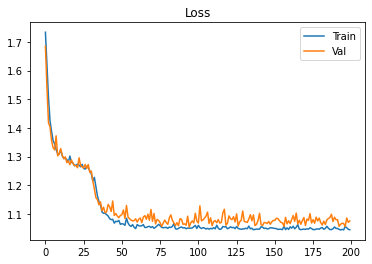

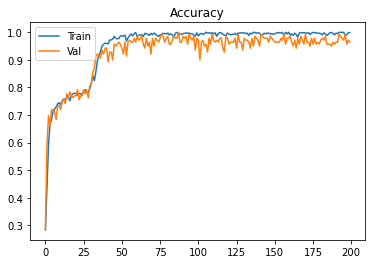

In [10]:
plt.figure(1)
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Loss")
plt.legend(("Train", "Val"))

plt.figure(2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_val_accuracy)
plt.title("Accuracy")
plt.legend(("Train", "Val"))

In [11]:
max(epoch_val_accuracy)

tensor(1., device='cuda:0')